In [89]:
%matplotlib notebook
import math
import glob
import requests
from datetime import timedelta
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import urllib.request
from bs4 import BeautifulSoup
import astropy.units as u
from astropy.io import fits
from astropy.io import ascii
from astropy.time import Time
from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip
from astropy.table import QTable
from astroquery.jplhorizons import Horizons
from photutils import centroid_com,centroid_sources
from photutils import CircularAperture, aperture_photometry
from photutils.aperture import CircularAperture, CircularAnnulus
from astropy.wcs import utils
from astroquery.jplhorizons import Horizons
import warnings
warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>


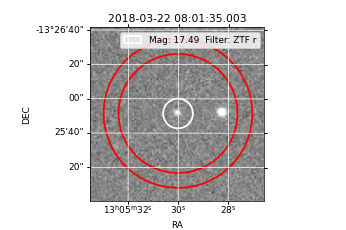

<IPython.core.display.Javascript object>


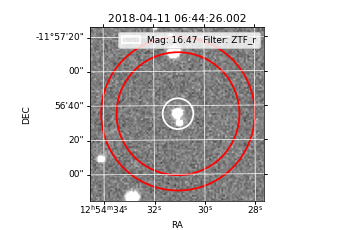

<IPython.core.display.Javascript object>


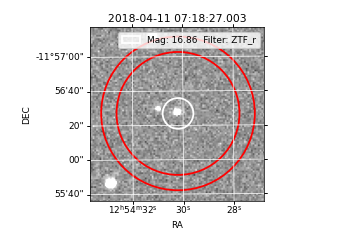

<IPython.core.display.Javascript object>


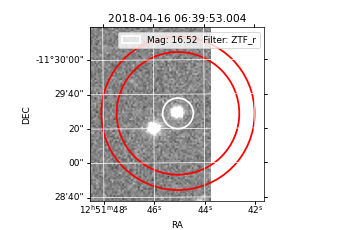

<IPython.core.display.Javascript object>


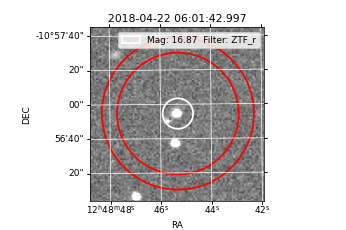

<IPython.core.display.Javascript object>


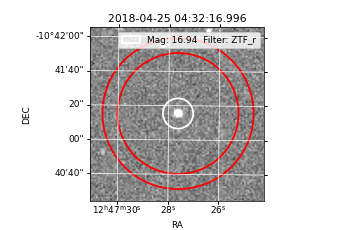

<IPython.core.display.Javascript object>


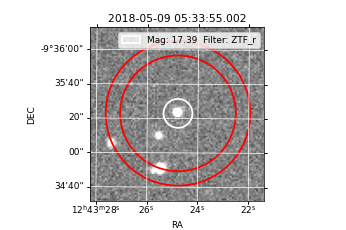

<IPython.core.display.Javascript object>


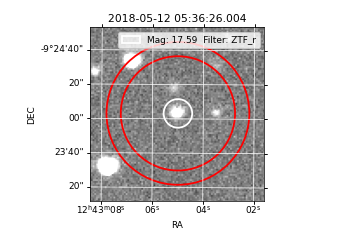

<IPython.core.display.Javascript object>


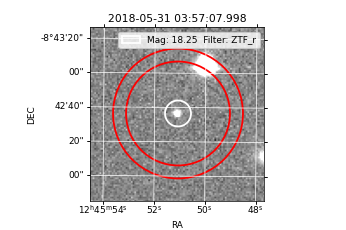

<IPython.core.display.Javascript object>


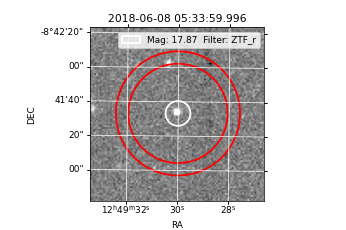

<IPython.core.display.Javascript object>


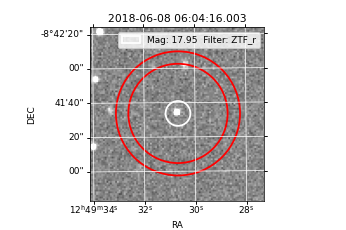

<IPython.core.display.Javascript object>


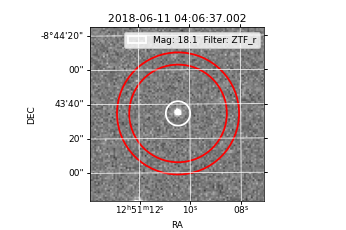

<IPython.core.display.Javascript object>


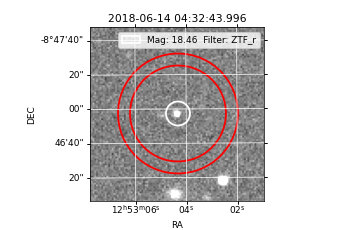

<IPython.core.display.Javascript object>


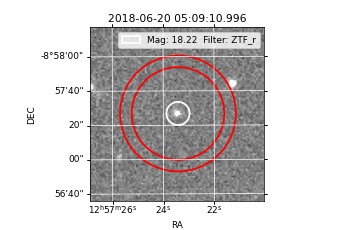

<IPython.core.display.Javascript object>


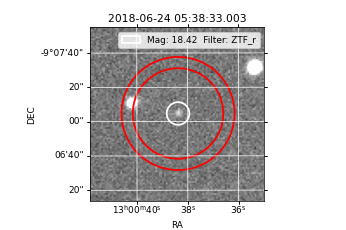

In [117]:
path = '/home/jmurtagh/143P/'
fitses = []
Msun_r = -26.93
Msun_i = -27.05
afrho_r = []
afrho_i = []
mag = []
filters = []
date = []
mjd = []
alpha = []
rh = []

''' read in fits files from desired path and add them to list to be analysed '''
for name in sorted(glob.glob(path+'*.fits')):
    fitses.append(name)

for i in range(len(fitses)):
    ''' read in the fits file and open up image data and header '''
    fname = fitses[i][fitses[i].find('ztf_'):]
    hdu = fits.open(fname)
    imgdiff = hdu[0].data
    hdr = hdu[0].header
    
    ''' take the time of observation from the fits header and use it to create 
        a date range for the epochs for astroquery by adding on one day.  '''
    dtime = Time(f'{hdr["OBSMJD"]}', format = 'mjd')
    dtime.format = 'iso'
    dtime2 = dtime + timedelta(days=1)
    
    ''' query jpl horizons using the date range and with the object id found on
        the online jpl horizons service first '''
    obj = Horizons(id='90001051', location='I41', epochs={'start':dtime.iso, 'stop':dtime2.iso, 'step':'1d'})
    eph = obj.ephemerides(quantities='1,19,20,24') #1 = RA + DEC (/decimal degrees, icrf), 19(r) = heliocentric comet dist (/AU), 20(delta) = observer-comet dist (/AU), 24(alpha) = phase angle (/degrees)
    
    ''' using small angle & s=r*theta, calculate the aperture radius in pixels
        for a 10^4km radius aperture. header contains scale of arcsecs/pixel '''
    delta_au = eph['delta'][0] * u.au
    delta_km = delta_au.to(u.km)
    theta_rad = ((10000*u.km)/(delta_km)) * u.rad
    theta_arcs = theta_rad.to(u.arcsec)
    pix = theta_arcs / hdr['PIXSCALE'] * (1/u.arcsec)
    
    ''' read in relevant details for calculations from header '''
    exptime = hdr['EXPTIME']
    gain = hdr['GAIN']
    rdnoise = hdr['READNOI']
    dark = hdr['DARKCUR']
    zp = hdr['MAGZP']
    wcs = WCS(hdr)
    
    ''' use RA & DEC guesses from jpl horizons to create skycoord object, turn those 
        into pixel values, and then use centroid_sources to hone in on object in image '''
    coords = SkyCoord(ra=eph['RA'][0], dec=eph['DEC'][0], frame='icrs', unit='deg')
    x, y = wcs.world_to_pixel(coords)
    xcent, ycent = centroid_sources(imgdiff, x, y, box_size=10, centroid_func=centroid_com)
    
    ''' using pixel scale calculated, create circular aperture and annulus around object
        with desired radii '''
    ap_radii=float(pix)
    aperture = CircularAperture((xcent[0],ycent[0]), r=ap_radii)
    annulus_aperture = CircularAnnulus((xcent[0],ycent[0]), r_in=4*float(pix), r_out=5*float(pix))
    annulus_mask = annulus_aperture.to_mask(method='center')
    
    ''' perform photometry on image '''
    phot = aperture_photometry(imgdiff, aperture)
    
    ''' '''
    annulus_data = annulus_mask.multiply(imgdiff)
    annulus_data_1d = annulus_data[annulus_mask.data > 0]
    _, bkg_median, _ = sigma_clipped_stats(annulus_data_1d)
    phot['sky_bkg'] = bkg_median
    
    ''' '''
    phot['aper_sky'] = bkg_median * aperture.area
    phot['counts_minus_sky'] = phot['aperture_sum'] - phot['aper_sky'] 
    n_target=phot['counts_minus_sky']
    n_sky=phot['aper_sky']
    n_dark=dark*exptime
    err_electrons=np.sqrt(gain*n_target + gain*n_sky + n_dark*aperture.area + rdnoise*rdnoise*aperture.area)
    err_adus=err_electrons/gain
    phot['uncertainty'] = err_adus
      
    ''' calculate a magnitude from the counts calculated. if the magnitude returns a nan
        value, ignore it and skip to the next image as it will be useless data. otherwise,
        plot the image centered on the comet with the aperture overplotted and magnitude
        and filter labelled, and append any useful details to lists at end'''
    m = -2.5 * np.log10(phot['counts_minus_sky']) + zp
    if math.isnan(m[0]) == True:
        pass
    else:
        fig = plt.figure()
        ax = plt.subplot(projection = wcs)
        plt.imshow(imgdiff, cmap='gray', norm=ImageNormalize(imgdiff, interval=ZScaleInterval()))
        plt.xlim(int(xcent)-50, int(xcent)+50)
        plt.ylim(int(ycent)-50, int(ycent)+50)
        
        plt.grid(color='w', which='major')
        plt.xlabel('RA')
        plt.ylabel('DEC')
        
        ap_patches = aperture.plot(color='white', lw=2)
        ann_patches = annulus_aperture.plot(color='red', lw=2)
        
        plt.title(f'{dtime}')
        plt.legend([ap_patches],[f'Mag: {m[0]:.4}  Filter: {hdr["FILTER"]}'])
        plt.show()
        
        mag.append(m[0])
        filters.append(hdr['FILTER'])
        date.append(dtime)
        mjd.append(hdr['OBSMJD'])
        alpha.append(eph['alpha'][0])
        rh.append(eph['r'][0])
    
        ''' calculate the afrho value for the specified filter that the image being analysed
            is in (found in the header value) using the magnitude of the sun in said filter '''
        if hdr['FILTER'] == 'ZTF r' or 'ZTF_r':
            afrho_r.append((((10**(-0.4 * (m[0] - Msun_r))) *(4 * eph['r'][0]**2 * delta_km**2 )/(10000 * u.km)).to(u.cm)).value)
        else:
            afrho_i.append((((10**(-0.4 * (m[0] - Msun_i))) *(4 * eph['r'][0]**2 * delta_km**2 )/(10000 * u.km)).to(u.cm)).value)
    

In [121]:
mags = QTable([mag, alpha, rh, mjd], names=['Magnitude', 'Phase Angle', 'Rh /AU','MJD'])
print(mags)

    Magnitude      Phase Angle     Rh /AU          MJD     
------------------ ----------- -------------- -------------
 17.49495655285821      7.5814 2.552149510944 58199.3344329
16.473741065697286       2.695 2.538663480209 58219.2808565
16.856306818511474       2.701 2.538651881979 58219.3044792
 16.52438607641401      4.3418 2.536442855009 58224.2776968
 16.86661179059765      6.7062 2.534403904386 58230.2511921
 16.93723421398196      7.8859 2.533647961591 58233.1890856
 17.38813128691862     13.1538 2.532291342599 58247.2318866
17.593807081161128     14.1573 2.532486261841 58250.2336343
18.252451257571522     19.2282 2.537642484263 58269.1646759
17.874183559522297     20.7223 2.541886918613 58277.2319444
   17.947414080788     20.7258 2.541899561753  58277.252963
18.103829575460395     21.1716 2.543734577261 58280.1712616
18.459269414349336     21.5826 2.545798173422 58283.1893981
18.223239897694107      22.255 2.550419133402 58289.2147106
18.418005273499276     22.5997 2.5538713

<IPython.core.display.Javascript object>


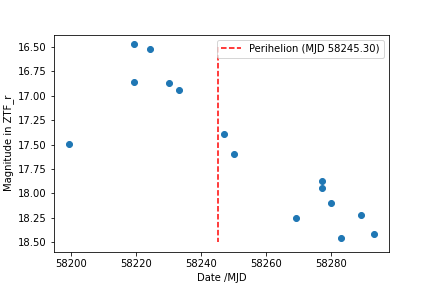

<function matplotlib.pyplot.show(block=None)>

In [101]:
fig = plt.figure()
plt.scatter(mags['MJD'], mags['Magnitude'])
plt.gca().invert_yaxis()
perihelion_jd = 2458245.80250
perihelion_mjd = perihelion_jd - 2400000.5
peri = plt.vlines(perihelion_mjd, ymin=16.5, ymax=18.5, linestyle='dashed', color='r', label = f'Perihelion (MJD {perihelion_mjd:.2f})')
plt.xlabel('Date /MJD')
plt.ylabel('Magnitude in ZTF_r')
plt.legend()
plt.show

<IPython.core.display.Javascript object>


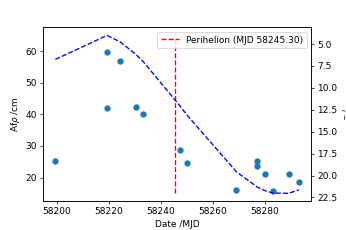

<function matplotlib.pyplot.show(block=None)>

In [134]:
fig, ax1 = plt.subplots()
ax1.scatter(mags['MJD'], afrho_r)
perihelion_jd = 2458245.80250
perihelion_mjd = perihelion_jd - 2400000.5
peri = plt.vlines(perihelion_mjd, ymin=15, ymax=65, linestyle='dashed', color='r', label = f'Perihelion (MJD {perihelion_mjd:.2f})')
ax1.set_xlabel('Date /MJD')
ax1.set_ylabel(r'Af$\rho$ /cm')
ax1.legend()

ax2 = ax1.twinx()
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(mags['MJD'], alpha)
spl.set_smoothing_factor(10)
ax2.plot(mags['MJD'], spl(mags['MJD']), linestyle = 'dashed', color = 'b')
ax2.invert_yaxis()

plt.show